## Notebook Setup and Uploading of Data to S3

In [192]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
!pip install -Uq altair torchtext torchdata

In [194]:
import sagemaker

In [454]:
!mkdir -p nn_gen_src
import sys
sys.path.append('nn_src')
sys.path.append('nn_gen_src')

In [452]:
!touch nn_gen_src/train_dummy
BUCKET = sagemaker.Session().default_bucket()
s3_data_url = f's3://{BUCKET}/nn/'
!aws s3 sync nn_gen_src {s3_data_url} --exclude '*' --include 'train_dummy'

upload: nn_gen_src/train_dummy to s3://sagemaker-eu-west-1-811243659808/nn/train_dummy


In [455]:
# %%writefile nn_src/requirements.txt
# torchtext
# torchdata

Writing nn_src/requirements.txt


In [456]:
# %%writefile nn_src/trenc.py

# import math

# import torch
# from torch import nn
# import torch.nn.functional as F 
# from torch import log

# class EncoderLayer(nn.Module):
#     def __init__(self,
#                  d,
#                  num_heads,
#                  dropout,
#                  ff_dim, 
#                  res_connections):

#         super().__init__()

#         projection_size = d // num_heads

#         self.WQ = nn.Parameter(torch.randn(num_heads, d, projection_size)/math.sqrt(d))
#         self.WK = nn.Parameter(torch.randn(num_heads, d, projection_size)/math.sqrt(d))
#         self.WV = nn.Parameter(torch.randn(num_heads, d, projection_size)/math.sqrt(d))
#         self.WO = nn.Parameter(torch.randn(num_heads, projection_size, d)/math.sqrt(d))

#         self.attn_norm = nn.LayerNorm(d)
#         self.ff_norm   = nn.LayerNorm(d)
#         self.dropout   = nn.Dropout(p=dropout)
#         self.ff        = nn.Sequential(
#             nn.Linear(d, int(ff_dim*d)), 
#             nn.GELU(),
#             nn.Dropout(p=dropout),
#             nn.Linear(int(ff_dim*d), d)
#         )

#         self.res_connections = res_connections
#         # Why just one ReLU/GELU, one dropout? Attention is all you need: 4.3, 5.4. 
        
#     def forward(self, input):

#         X, prv_attention_values = input

#         # b batch
#         # t step
#         # d dimension
#         # p projected dimension
#         # h head
        
#         normalized_X = self.attn_norm(X) # Pre-Norm

#         # Creating keys, queries and values from the normalized values, while
#         # at the same time down projecting from d dimensions to p dimensions
#         keys    = torch.einsum('btd,hdp->bthp', normalized_X, self.WK)
#         queries = torch.einsum('btd,hdp->bthp', normalized_X, self.WQ)
#         values  = torch.einsum('btd,hdp->bthp', normalized_X, self.WV)

#         # Attention values are per position, not per dimension etc.
#         dot = torch.einsum('bkhp,bqhp->bhqk', queries, keys)
#         scaled_dot = dot / math.sqrt(values.size()[-1])
#         attention_values = torch.softmax(scaled_dot, -1)

#         assert torch.allclose(attention_values[0, 0, 0].sum(), torch.tensor(1.))

#         new_values = torch.einsum('bkhp,bhqk->bqhp', values, attention_values)
#         b, t, h, p = new_values.size()

#         # Consolidate the invidual head outputs by concenating them
#         # and then up projecting from p to d dimensions.
#         seq_summary = torch.einsum('bthp,hpd->btd', new_values, self.WO)
        
#         # Alternatively: 
#         # Concat outputs of the individual heads
#         # Using no learnable parameters
#         # seq_summary = new_values.view(b, t, -1)

#         assert seq_summary.size()[-1] == h*p == X.size()[-1]

#         # Residual Connection and Pre-Norm
#         if self.res_connections:
#             pre_ff = X + self.ff_norm(seq_summary) 
#         else:
#             pre_ff = self.ff_norm(seq_summary) 

#         prv_attention_values.append(attention_values)

#         post_ff = self.ff(self.dropout(pre_ff))
#         if self.res_connections:
#             return post_ff + pre_ff, prv_attention_values
#         else:
#             return post_ff, prv_attention_values


# class TrEnc(nn.Module):
#     def __init__(self, 
#                  num_classes, 
#                  vocab_size, 
#                  layers,
#                  d,
#                  heads,
#                  dropout,
#                  use_pos_enc,
#                  use_cls_token,
#                  clf_scale,
#                  ff_dim, 
#                  **kwargs):
#         super().__init__()
        
#         print(f'superfluous model parameters not used: {kwargs}')

#         res_connections=True
#         pos_encoding = 'sin' if use_pos_enc else None
        
#         embed_size = d*heads 
#         self.pooling  = 'cls' if use_cls_token else 'mean'
        
#         self.res_connections = res_connections == True
  
#         self.embeddings = nn.Embedding(vocab_size, embed_size, padding_idx=1)
#         self.encoder_layers = \
#             nn.Sequential(
#                 *[EncoderLayer(embed_size, heads, dropout, ff_dim, res_connections) for _ in range(layers)],)

#         # Empricially it was a toss-up if the additional LN helped or not
#         # It is part of the Pre-LN Transformer though
#                 #nn.LayerNorm(embed_size))
        
#         # REVIEW: Just have one matrix for all three weight matrices?
#         # REVIEW: Maybe do not project the values, but q and k only
        
#         self.dropout     = nn.Dropout(dropout)
        
#         if clf_scale:
#             intermediate_dim = int(embed_size*clf_scale)
#             self.clf = nn.Sequential(
#                 nn.Linear(embed_size, intermediate_dim, bias=False),
#                 nn.LayerNorm(intermediate_dim),
#                 nn.Tanh(),
#                 nn.Dropout(dropout/2),
#                 nn.Linear(intermediate_dim, num_classes)
#             )
#         else:
#             self.clf = nn.Linear(embed_size, num_classes)
            
#         self.pos_encoder = PositionalEncoding(embed_size, dropout) if use_pos_enc else None

#     def extra_repr(self):
#         return f'residual_connection={self.res_connections}, pooling={self.pooling}'

#     def forward(self, X, output_attentions=False):
#         # TODO: Unclear how helpful dropout on embeddings is here. Same p? 
#         emb = self.dropout(self.embeddings(X))

#         if self.pos_encoder:
#             emb = self.pos_encoder(emb) 

#         z, attention_values = self.encoder_layers((emb, []))
        
#         if self.pooling == 'cls':
#             logits = self.clf(self.dropout(z[:, 0]))
#         elif self.pooling == 'mean':
#             logits = self.clf(self.dropout(z.mean(1)))
#         else:
#             raise ValueError('Only mean and cls are valid valued for pooling.')

#         if output_attentions:
#             # return attention as b, l, h, q, k
#             return logits, torch.stack(attention_values, 0).transpose(0, 1)
#         return logits

# # From: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:x.size(0), :]
#         return self.dropout(x)


Writing nn_src/trenc.py


In [457]:
# %%writefile nn_src/cnn.py

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

                
# class CNN(nn.Module):
#     def __init__(self,
#                  vocab_size,
#                  num_classes,
#                  d, 
#                  kernel_sizes,
#                  num_filters,
#                  strides,
#                  dropout,
#                  **kwargs):

#         super().__init__()
#         print(f'superfluous model parameters not used: {kwargs}')
#         assert len(num_filters) == len(kernel_sizes) == len(strides), 'Same number of values for kernel_sizes, num_filters and strides must be specified.'
       
#         self.embeddings = nn.Embedding(vocab_size, d, padding_idx=1)
        
#         layers = []
#         layers.append(Multihead([self._create_conv(
#             d, 
#             num_filters[i], 
#             kernel_sizes[i], 
#             dropout, 
#             strides[i]
#         ) for i in range(len(kernel_sizes))]))
        
#         ff_in = sum(num_filters)
        
#         self.nn = nn.Sequential(
#             *layers,
#             nn.BatchNorm1d(ff_in),
#             MaxOverTimePooling(),
#             nn.Linear(ff_in, num_classes))

#     def forward(self, X):
#         emb = self.embeddings(X).transpose(2, 1)
        
#         return self.nn(emb)

#     def _create_conv(self,
#                      in_channels,
#                      out_channels,
#                      kernel_size,
#                      dropout,
#                      stride):
        
#         padding = int((kernel_size-1)//2)
        
#         return nn.Sequential(
#             nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding),
#             nn.BatchNorm1d(out_channels),
#             nn.ReLU(),
#             nn.Dropout(p=dropout))

# class MaxOverTimePooling(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#     def forward(self, x):
#         return torch.max(x, -1)[0]

# class Cat(nn.Module):
#     def __init__(self, dim=0):
#         super().__init__()
#         self.dim = dim
#     def forward(self, x):
#         return torch.cat(x, dim=self.dim)
#     def extra_repr(self):
#         return str(f'dim={self.dim}')

# class Multihead(nn.Module):
#     def __init__(self, heads, dim=1):
#         super().__init__()
#         self.heads = nn.ModuleList(heads)
#         self.cat = Cat(dim)

#     def forward(self, x):
#         outputs = [head(x) for head in self.heads]
#         return self.cat(outputs)


Writing nn_src/cnn.py


In [458]:
# %%writefile nn_src/util.py

# from ast import literal_eval

# def count_parameters(m, verbose=True):
#     total_count = 0
#     learnable_count = 0
#     if verbose:
#         print('Parameters (name, tunable, count):')
#     for n, p in m.named_parameters():
#         count = p.data.numel() 
#         if verbose:
#             print(f' {n:60s} {p.requires_grad:5b} {count:>9d}')
#         total_count += count
#         if p.requires_grad:
#             learnable_count += count
#     if verbose:
#         print(f'Total parameters: {total_count}, thereof learnable: {learnable_count}')
#     return total_count, learnable_count

# def str2bool(v):
#     if isinstance(v, bool):
#         return v
#     if v.lower() in ('yes', 'true', 't', 'y', '1'):
#         return True
#     elif v.lower() in ('no', 'false', 'f', 'n', '0'):
#         return False
#     else:
#         raise argparse.ArgumentTypeError('Boolean value expected.')
        
# def str2ints(v):
#     assert isinstance(v, str)
    
#     obj = literal_eval(v)
#     assert isinstance(obj, list), f'parsed value needs to be a list, not {type(obj)}'
#     for elem in obj:
#         assert isinstance(elem, int)
    
#     return obj

Writing nn_src/util.py


In [459]:
# %%writefile nn_src/prepare.py

# import random
# from pathlib import Path
# from collections import namedtuple

# import torch
# from torch.utils.data import DataLoader
# import torchdata.datapipes as dp

# from torchtext.datasets import IMDB
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator

# from torchtext.data.functional import generate_sp_model, load_sp_model, sentencepiece_tokenizer

# def _get_sp_tokenizer(train_dp):
    
#     input_file = Path('data')/'sp_input'
#     output_dir = Path('data')/'sp_out'

#     if not input_file.exists():
#         with open(input_file, 'w') as f:
#             for _, text in train_dp:
#                 f.write(text+'\n')
    
#     if not output_dir.exists():    
#         output_dir.mkdir(exist_ok=True)

#         # Outputs, among others: Updating active symbols. max_freq=705466 min_freq=168    
#         generate_sp_model(str(input_file), vocab_size=4000, model_type='bpe', model_prefix=f'{output_dir}/sp_out')
        
#     sp_model = load_sp_model(str(output_dir/'sp_out.model'))
    
#     sp_tokenizer = sentencepiece_tokenizer(sp_model)
# #l = list(tokenizer(['one two three', 'four five six', 'example to try', 'washing machine running automation']))
#     return tokenizer

# def _get_tokenizer_and_vocab(tokenizer_type, vocab_size, train_dp):
    
#     if tokenizer_type == 'basic':
#         tokenizer = get_tokenizer('basic_english')
#     else: 
#         tokenizer = _get_sp_tokenizer(train_dp)
    
#     vocab = build_vocab_from_iterator(
#         map(tokenizer, (text for (_, text) in train_dp)), specials=['<UNK>', '<PAD>'], 
#         max_tokens=vocab_size
#     )
#     vocab.set_default_index(vocab['<UNK>'])
    
#     return tokenizer, vocab


# def prepare_data(tokenizer_type, batch_size, vocab_size, max_input_len, device):
    
#     train_dp, valid_dp = IMDB(root='imdb_data', split=('train', 'test'))
    
#     tokenizer, vocab = _get_tokenizer_and_vocab(tokenizer_type, vocab_size, train_dp)
    
#     print(f'Vocabulary built with {len(vocab.get_itos())} tokens.')
    
#     ### Data Loaders and methods
#     def vectorize(y, x):
#         y = 0 if y == 'neg' else 1
#         return (y, vocab(tokenizer(x)))
    
#     def collate(data):
#         batch_len = min(max_input_len, max([len(x) for (_, x) in data]))
        
#         padding = [1] * batch_len # <PAD> has index 1
#         y, x = zip(*[(y, (x+padding)[:batch_len]) for (y, x) in data])
 
#         return torch.LongTensor(y).to(device), torch.LongTensor(x).to(device)
    
#     train_dl = DataLoader(
#         dataset=[vectorize(y, x) for (y, x) in train_dp], 
#         batch_size=batch_size, 
#         shuffle=True,
#         drop_last=True,
#         collate_fn=collate)
#     del train_dp
    
#     valid_ds = [vectorize(y, x) for (y, x) in valid_dp]
#     random.shuffle(valid_ds)
#     valid_dl = DataLoader(
#         dataset=valid_ds[:7500], 
#                 batch_size=batch_size*2,
#                 collate_fn=collate)  
    
#     return namedtuple('Data', 'train_dl valid_dl vocabulary')(
#         train_dl, valid_dl, vocab
#     )

Writing nn_src/prepare.py


In [460]:
# %%writefile nn_src/train.py

# import sys
# import argparse
# import math
# from time import time

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# from util import str2bool, str2ints, count_parameters
# from prepare import prepare_data
# from trenc import TrEnc
# from cnn import CNN

# def parse_args(arg_values_to_parse):
#     parser = argparse.ArgumentParser()

#     parser.add_argument('--epochs', type=int, default=1) 
#     parser.add_argument('--early-stopping-patience', type=int, default=0)
#     parser.add_argument('--batch-size', dest='bs', type=int, default=32) 
#     parser.add_argument('--lr', type=float, default=5e-5) 
    
#     parser.add_argument('--model', type=str, default='TrEnc')
#     parser.add_argument('--vocab-size',    type=int, default=10_000) 
#     parser.add_argument('--max-input-len', type=int, default=64) 
    
#     # model
#     parser.add_argument('--dropout', dest='m_dropout',type=float, default=0.2) 
#     parser.add_argument('--layers',  dest='m_layers',type=int, default=1) 
  
#     # dim is used for embedings. If a TrEnc, then embed_size = dim*heads
#     parser.add_argument('--dim', dest='m_d',     type=int, default=64) 
    
#     # model trenc
#     parser.add_argument('--heads',   dest='m_heads', type=int, default=8) 
#     parser.add_argument('--ff-dim',  dest='m_ff_dim',type=float, default=4.) 
#     parser.add_argument('--use-cls-token', dest='m_use_cls_token', type=str2bool, default=True)
#     parser.add_argument('--use-pos-enc',   dest='m_use_pos_enc',   type=str2bool, default=False)
#     parser.add_argument('--clf-scale',     dest='m_clf_scale', type=float, default=1.0)
    
#     # model cnn
#     parser.add_argument('--kernel-sizes', dest='m_kernel_sizes', type=str2ints, default='[1, 3]')
#     parser.add_argument('--num-filters',  dest='m_num_filters',  type=str2ints, default='[48, 48]')
#     parser.add_argument('--strides',      dest='m_strides',      type=str2ints, default='[1, 1]')
    
#     parser.add_argument('--dummy', dest='_ignore',type=float, default=0.) 
    
    
#     # FIXME: Should I add a separate pooler?
        
#     return parser.parse_args(arg_values_to_parse)

# def main(*arg_values_to_parse):
    
#     args = parse_args([str(la) for la in arg_values_to_parse])
#     print('Arguments:', args)
  
#     dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
#     data = prepare_data(tokenizer_type='bpe', # basic
#                         batch_size=args.bs, 
#                         vocab_size=args.vocab_size, 
#                         max_input_len=args.max_input_len,
#                         device=dev)
    
#     ### Model
#     # Instantiate model and pass all command line args that start with m_
#     model_args = {
#         'num_classes': 2, # neg, pos 
#         'vocab_size': len(data.vocabulary.get_itos()),
#         **{k[2:]: v for k, v in vars(args).items() if k.startswith('m_')}
#     }
    
#     model_cls = None
#     if args.model == 'TrEnc':
#         model_cls = TrEnc
#     elif args.model == 'CNN':
#         model_cls = CNN
    
#     model = model_cls(**model_args).to(dev)

#     print('Model instantiated:', model)

#     # prints 'learnable: ddd' to stdout
#     count_parameters(model)[1]
    
#     ### Train Loop
#     optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
#     criterion = nn.CrossEntropyLoss(reduction='sum')
        
#     scaler = torch.cuda.amp.GradScaler()
    
#     best_valid_loss = math.inf
#     best_epoch = None
    
#     #FIXME: documentation.
#     best_result_store = None 
    
#     for epoch in range(args.epochs):
#         model.train()
#         train_loss_epoch = 0.
#         train_count_epoch = 0
#         started = time()
    
#         for i, (Yb, Xb) in enumerate(data.train_dl): 
            
#             with torch.cuda.amp.autocast():
#                 logits = model(Xb)
            
#                 loss = criterion(logits, Yb)
            
#             scaler.scale(loss).backward()
            
#             scaler.step(optimizer)
#             scaler.update()
            
#             train_loss_epoch  += loss.item() 
#             train_count_epoch += len(Yb)
#             optimizer.zero_grad()

#             if i % 50 == 0: 
#                 print(f'i: {i:4d}: batch_train_loss: {loss/len(Yb):6.4f}')
                
#         model.eval()
#         with torch.no_grad():
#             valid_count_epoch = 0
#             matched_epoch = 0
#             valid_loss_epoch = 0.
            
#             for i, (Yb, Xb) in enumerate(data.valid_dl):
#                 with torch.cuda.amp.autocast():
#                     logits = model(Xb)
#                     valid_loss_epoch += criterion(logits, Yb).item()
                    
#                     predictions = logits.argmax(-1)
#                     matched_epoch += (predictions == Yb).sum().item()
#                     valid_count_epoch += len(Yb)

#             acc = matched_epoch/valid_count_epoch
        
#         log_message = f'ep: {epoch} train_loss: {train_loss_epoch/train_count_epoch:6.5f} valid_loss: {valid_loss_epoch/valid_count_epoch:6.5f} valid_acc: {acc:5.4f} took: {time()-started:5.3f}s'
#         print(log_message)
        
#         if valid_loss_epoch < best_valid_loss:
#             best_valid_loss = valid_loss_epoch
#             best_result_store = log_message
#             best_epoch = epoch
            
#             print(f'epoch {epoch} was the best epoch so far.')
            
#         # early stopping 
#         print(f'best epoch {best_epoch}, epoch {epoch}, diff {(epoch-best_epoch)}')
#         if best_epoch and epoch >= args.early_stopping_patience-1 and (epoch-best_epoch) >= args.early_stopping_patience:
#             print(f'No progress for {args.early_stopping_patience} epochs. Stopping early.')
#             break
                
#     print('End of training.')
#     print('Re-reporting best loss epoch:')
#     print(best_result_store)

# if __name__ == '__main__':
#     print('main', sys.argv)
#     main(*sys.argv[1:])    

Writing nn_src/train.py


!0!2.0
!1!1.5
!2!1.3
!3!1.3 (last improvement)
!4!1.4
!5!1.5
!6!1.6



In [ ]:
res ['i', 'rented', 'i', 'am', 'curious-yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', '.', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'u', '.', 's', '.', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', ',', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'myself', '.', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', '.', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues', 'in', 'the', 'united', 'states', '.', 'in', 'between', 'asking', 'politicians', 'and', 'ordinary', 'denizens', 'of', 'stockholm', 'about', 'their', 'opinions', 'on', 'politics', ',', 'she', 'has', 'sex', 'with', 'her', 'drama', 'teacher', ',', 'classmates', ',', 'and', 'married', 'men', '.', 'what', 'kills', 'me', 'about', 'i', 'am', 'curious-yellow', 'is', 'that', '40', 'years', 'ago', ',', 'this', 'was', 'considered', 'pornographic', '.', 'really', ',', 'the', 'sex', 'and', 'nudity', 'scenes', 'are', 'few', 'and', 'far', 'between', ',', 'even', 'then', 'it', "'", 's', 'not', 'shot', 'like', 'some', 'cheaply', 'made', 'porno', '.', 'while', 'my', 'countrymen', 'mind', 'find', 'it', 'shocking', ',', 'in', 'reality', 'sex', 'and', 'nudity', 'are', 'a', 'major', 'staple', 'in', 'swedish', 'cinema', '.', 'even', 'ingmar', 'bergman', ',', 'arguably', 'their', 'answer', 'to', 'good', 'old', 'boy', 'john', 'ford', ',', 'had', 'sex', 'scenes', 'in', 'his', 'films', '.', 'i', 'do', 'commend', 'the', 'filmmakers', 'for', 'the', 'fact', 'that', 'any', 'sex', 'shown', 'in', 'the', 'film', 'is', 'shown', 'for', 'artistic', 'purposes', 'rather', 'than', 'just', 'to', 'shock', 'people', 'and', 'make', 'money', 'to', 'be', 'shown', 'in', 'pornographic', 'theaters', 'in', 'america', '.', 'i', 'am', 'curious-yellow', 'is', 'a', 'good', 'film', 'for', 'anyone', 'wanting', 'to', 'study', 'the', 'meat', 'and', 'potatoes', '(', 'no', 'pun', 'intended', ')', 'of', 'swedish', 'cinema', '.', 'but', 'really', ',', 'this', 'film', 'doesn', "'", 't', 'have', 'much', 'of', 'a', 'plot', '.'], type: <class 'list'>
"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don't exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we're treated to the site of Vincent Gallo's throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, and the same cannot be said for a man. In fact, you generally won't see female genitals in an American film in anything short of porn or explicit erotica. This alleged double-standard is less a double standard than an admittedly depressing ability to come to terms culturally with the insides of women's bodies., type: <class 'str'>

In [448]:
# Uncomment the following line when you want to test your script locally (validate arg parsing for example)
#!python nn_src/train.py --epochs 20 --kernel-sizes '[1, 3]' --model 'CNN' --dim 32 --strides '[1, 1]' --num-filters '[12, 12]'

In [500]:
# Uncomment below to directly call the implementation. 
# To check if you have typos or mismatched dimensions, before you submit it to a container training.
# But also for example use PDB.
from nn_src.train import main as fit
fit('--epochs', 20,
    '--vocab-size', 1_000,
    '--batch-size', 128,
    '--lr', 1e-1, 
    '--layers', 1,
    '--dim', 8,
    '--ff-dim', 4,
    '--heads', 4,
    '--max-input-len', 64,
    '--early-stopping-patience', 2,
    '--clf-scale', 0.,
    '--model', 'CNN',
    '--dim', 32,
    '--strides', [1, 1],
    '--num-filters', [12, 12],
    '--kernel-sizes', [1, 3],
    '--tokenizer', 'basic'
)

Arguments: Namespace(epochs=20, early_stopping_patience=2, bs=128, lr=0.1, model='CNN', tokenizer='basic', vocab_size=1000, max_input_len=64, m_dropout=0.2, m_layers=1, m_d=32, m_heads=4, m_ff_dim=4.0, m_use_cls_token=True, m_use_pos_enc=False, m_clf_scale=0.0, m_kernel_sizes=[1, 3], m_num_filters=[12, 12], m_strides=[1, 1], _ignore=0.0)
Vocabulary built with 1000 tokens.
superfluous model parameters not used: {'layers': 1, 'heads': 4, 'ff_dim': 4.0, 'use_cls_token': True, 'use_pos_enc': False, 'clf_scale': 0.0}
Model instantiated: CNN(
  (embeddings): Embedding(1000, 32, padding_idx=1)
  (nn): Sequential(
    (0): Multihead(
      (heads): ModuleList(
        (0): Sequential(
          (0): Conv1d(32, 12, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
        (1): Sequential(
          (0): Conv1d(32, 12, kernel_size=(3,), stride=(

In [ ]:
%debug

In [ ]:
xxx

In [501]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

In [509]:
metric_definitions = [
    {'Name': 'Epoch',               'Regex': r'ep:\s+(-?[0-9\.]+)'},
    {'Name': 'Valid:Acc',           'Regex': r'valid_acc:\s+(-?[0-9\.]+)'},
    {'Name': 'Train:Loss',          'Regex': r'train_loss:\s+(-?[0-9\.]+)'},
    {'Name': 'Valid:Loss',          'Regex': r'valid_loss:\s+(-?[0-9\.]+)'}, 
    {'Name': 'LearnableParameters', 'Regex': r'learnable:\s+(-?[0-9\.]+)'} 
]                                 

In [510]:
estimator = PyTorch(
    'train.py',
    source_dir='nn_src',
    role=get_execution_role(),
    instance_type= 'ml.g4dn.xlarge',
    instance_count=1,
    framework_version='1.10',
    py_version='py38',
    metric_definitions=metric_definitions,
    base_job_name='nn',

    use_spot_instances= True,
    max_run=  60 * 60 * 24,
    max_wait= 60 * 60 * 24,

    keep_alive_period_in_seconds= 120,

    hyperparameters = {'early-stopping-patience': 5, 
                       'epochs': 20,
                       'batch-size': 128,
                       'lr': 2e-4,
                       'vocab-size': 4_000,
                       'tokenizer': 'bpe', 
                       'heads': 12,
                       'dim': 32, 
                       'max-input-len': 256,
                       'layers': 1,
                       'dropout': 0.25, 
                       'use-cls-token': True,
                       'use-pos-enc': True,
                       'clf-scale': 1.,
                       'ff-dim': 4.,
                       
                       
                       'model': 'CNN', # 'TrEnc', 'CNN'
                       'dim': 128,
                       'max-input-len': 2048,
                       'strides': '\'[1, 1, 1]\'',
                       'num-filters': '\'[12, 12, 12]\'',
                       'kernel-sizes': '\'[1, 3, 7]\'',
                      }
    ) 

In [511]:
estimator.fit({'train': s3_data_url+'train_dummy'}, wait=False)

### Automatic Model Tuning Jobs
#### Random Sweep to check the lay of the land

In [514]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner
# next: vocab-size

hpt_ranges = {
    #'dummy': ContinuousParameter(0, 1, 'Linear'), 
    'vocab-size': IntegerParameter(500, 10_000),
    'tokenizer': CategoricalParameter(['bpe', 'basic']),
    #'lr': ContinuousParameter(1e-6, 1e-2), 
    #'max-input-len': IntegerParameter(10, 768),
    #'dropout': ContinuousParameter(0.2, 0.6),
    #'heads': IntegerParameter(4, 16),
    #'dim': IntegerParameter(8, 128),
    #'ff-dim': ContinuousParameter(0.1, 10, 'Linear'),
    #'layers': IntegerParameter(1, 12),
    #'layers': CategoricalParameter([1, 4, 8]),
    #'model': CategoricalParameter(['SentimentNN', 'TrEnc']),
    #'use-pos-enc': CategoricalParameter([True, False]),
    #'use-cls-token': CategoricalParameter([True, False])
    #'clf-scale': CategoricalParameter([0.5, 2.0])
}

tuner_parameters = {'estimator': estimator,
                    'base_tuning_job_name': 'v-size-tzer',
                    'metric_definitions': metric_definitions,
                    
                    'objective_metric_name': 'Valid:Acc',
                    'objective_type': 'Maximize',
                    'hyperparameter_ranges': hpt_ranges,
                    'strategy': 'Random',
                    'early_stopping_type': 'Off',
                    
                    'max_jobs': 30,           # Was: 20 
                    'max_parallel_jobs': 3}   # Was: 20

In [515]:
tuner = HyperparameterTuner(**tuner_parameters)
tuner.fit({'train': s3_data_url+'train_dummy'}, wait=False)
tuner_name = tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {tuner_name}.')

tuning job submitted: v-size-tzer-221024-1902.


In [ ]:
# ClientError: An error occurred (ValidationException) when calling the CreateHyperParameterTuningJob operation: You don't have enough combinations of hyperparameter ranges. The total number of hyperparameter combinations for the provided ranges [6.0] must be equal or greater than the value of MaxNumberOfJobs, [75]. Provide additional ranges.
# which means I cannot use warm start, nor can I use Bayesian

In [516]:
# trenc

model      = 'model-221020-1931'
layers     = 'layers-221020-1931'
md_lr      = ['model-lr-tr-221020-2000', 'model-lr-nn-221020-2001', 'model-lr-nn-221021-1022']
pos_enc    = 'pos-enc-221020-2003'
pos_enc_lr = ['pe-t-lr-221020-2140', 'pe-f-lr-221020-2141']
ff_dim     = ['ff-dim-221021-1242']
dropout    = 'dropout-221021-1541'
input_len  = 'input-len-221021-1542'
vocab_size = 'input-len-221021-1631'
beefy_c_l  = ['beefy-layers-221021-2041', 'beefy-layers-221022-1013'] # and multi layers
beefy_c_l  = 'beefy-layers-221022-1013'
clf_scl_la = ['clf-scale-la-221022-1317', 'clf-scale-la-221022-2248'] # and multi layers

# cnn
sweep      = 'cnn-sweep-221021-1921'
inp_len    = ['cnn-in-len-221023-1140', 'cnn-in-len-221023-1755']
inp_len2   = [ 'cnn-in-len-221023-1755']
v_size_to  = 'v-size-tzer-221024-1902'

Tuning job cnn-in-len-221023-1755    status: Completed

Number of training jobs with valid objective: 20
Lowest: 0.7540000081062317 Highest 0.8639000058174133


max-input-len                      TrainingJobName TrainingJobStatus   TrainingStartTime     TrainingEndTime  TrainingElapsedTimeSeconds           TuningJobName  Valid:Acc
11          481.0  cnn-in-len-221023-1755-009-bb0c257d         Completed 2022-10-23 17:17:48 2022-10-23 17:25:06                       438.0  cnn-in-len-221023-1755     0.8639
16          510.0  cnn-in-len-221023-1755-004-436060e0         Completed 2022-10-23 16:27:14 2022-10-23 16:34:08                       414.0  cnn-in-len-221023-1755     0.8624
2           562.0  cnn-in-len-221023-1755-018-7426650c         Completed 2022-10-23 18:44:22 2022-10-23 18:51:35                       433.0  cnn-in-len-221023-1755     0.8563
4           614.0  cnn-in-len-221023-1755-016-ddf6546f         Completed 2022-10-23 18:25:32 2022-10-23 18:32:20                       408.0  cnn-in-len-221023-1755     0.8563
15          576.0  cnn-in-len-221023-1755-005-1f89de43         Completed 2022-10-23 16:37:43 2022-10-23 16:44:42                       419.0  cnn-in-len-221023-1755     0.8556
8           640.0  cnn-in-len-221023-1755-012-0fe46cef         Completed 2022-10-23 17:45:30 2022-10-23 17:52:43                       433.0  cnn-in-len-221023-1755     0.8539
3           651.0  cnn-in-len-221023-1755-017-c86ea01f         Completed 2022-10-23 18:35:34 2022-10-23 18:42:47                       433.0  cnn-in-len-221023-1755     0.8531
6           403.0  cnn-in-len-221023-1755-014-afb7e44a         Completed 2022-10-23 18:06:16 2022-10-23 18:13:24                       428.0  cnn-in-len-221023-1755     0.8525
14          606.0  cnn-in-len-221023-1755-006-a1fe6004         Completed 2022-10-23 16:47:08 2022-10-23 16:54:20                       432.0  cnn-in-len-221023-1755     0.8508
17          457.0  cnn-in-len-221023-1755-003-6d965aa8         Completed 2022-10-23 16:17:04 2022-10-23 16:24:07                       423.0  cnn-in-len-221023-1755     0.8495

Retrieving metrics cache Hit/Miss: HHMMHHMHHHMMHHHHHHHM
CPU times: user 984 ms, sys: 53.9 ms, total: 1.04 s
Wall time: 7.62 s


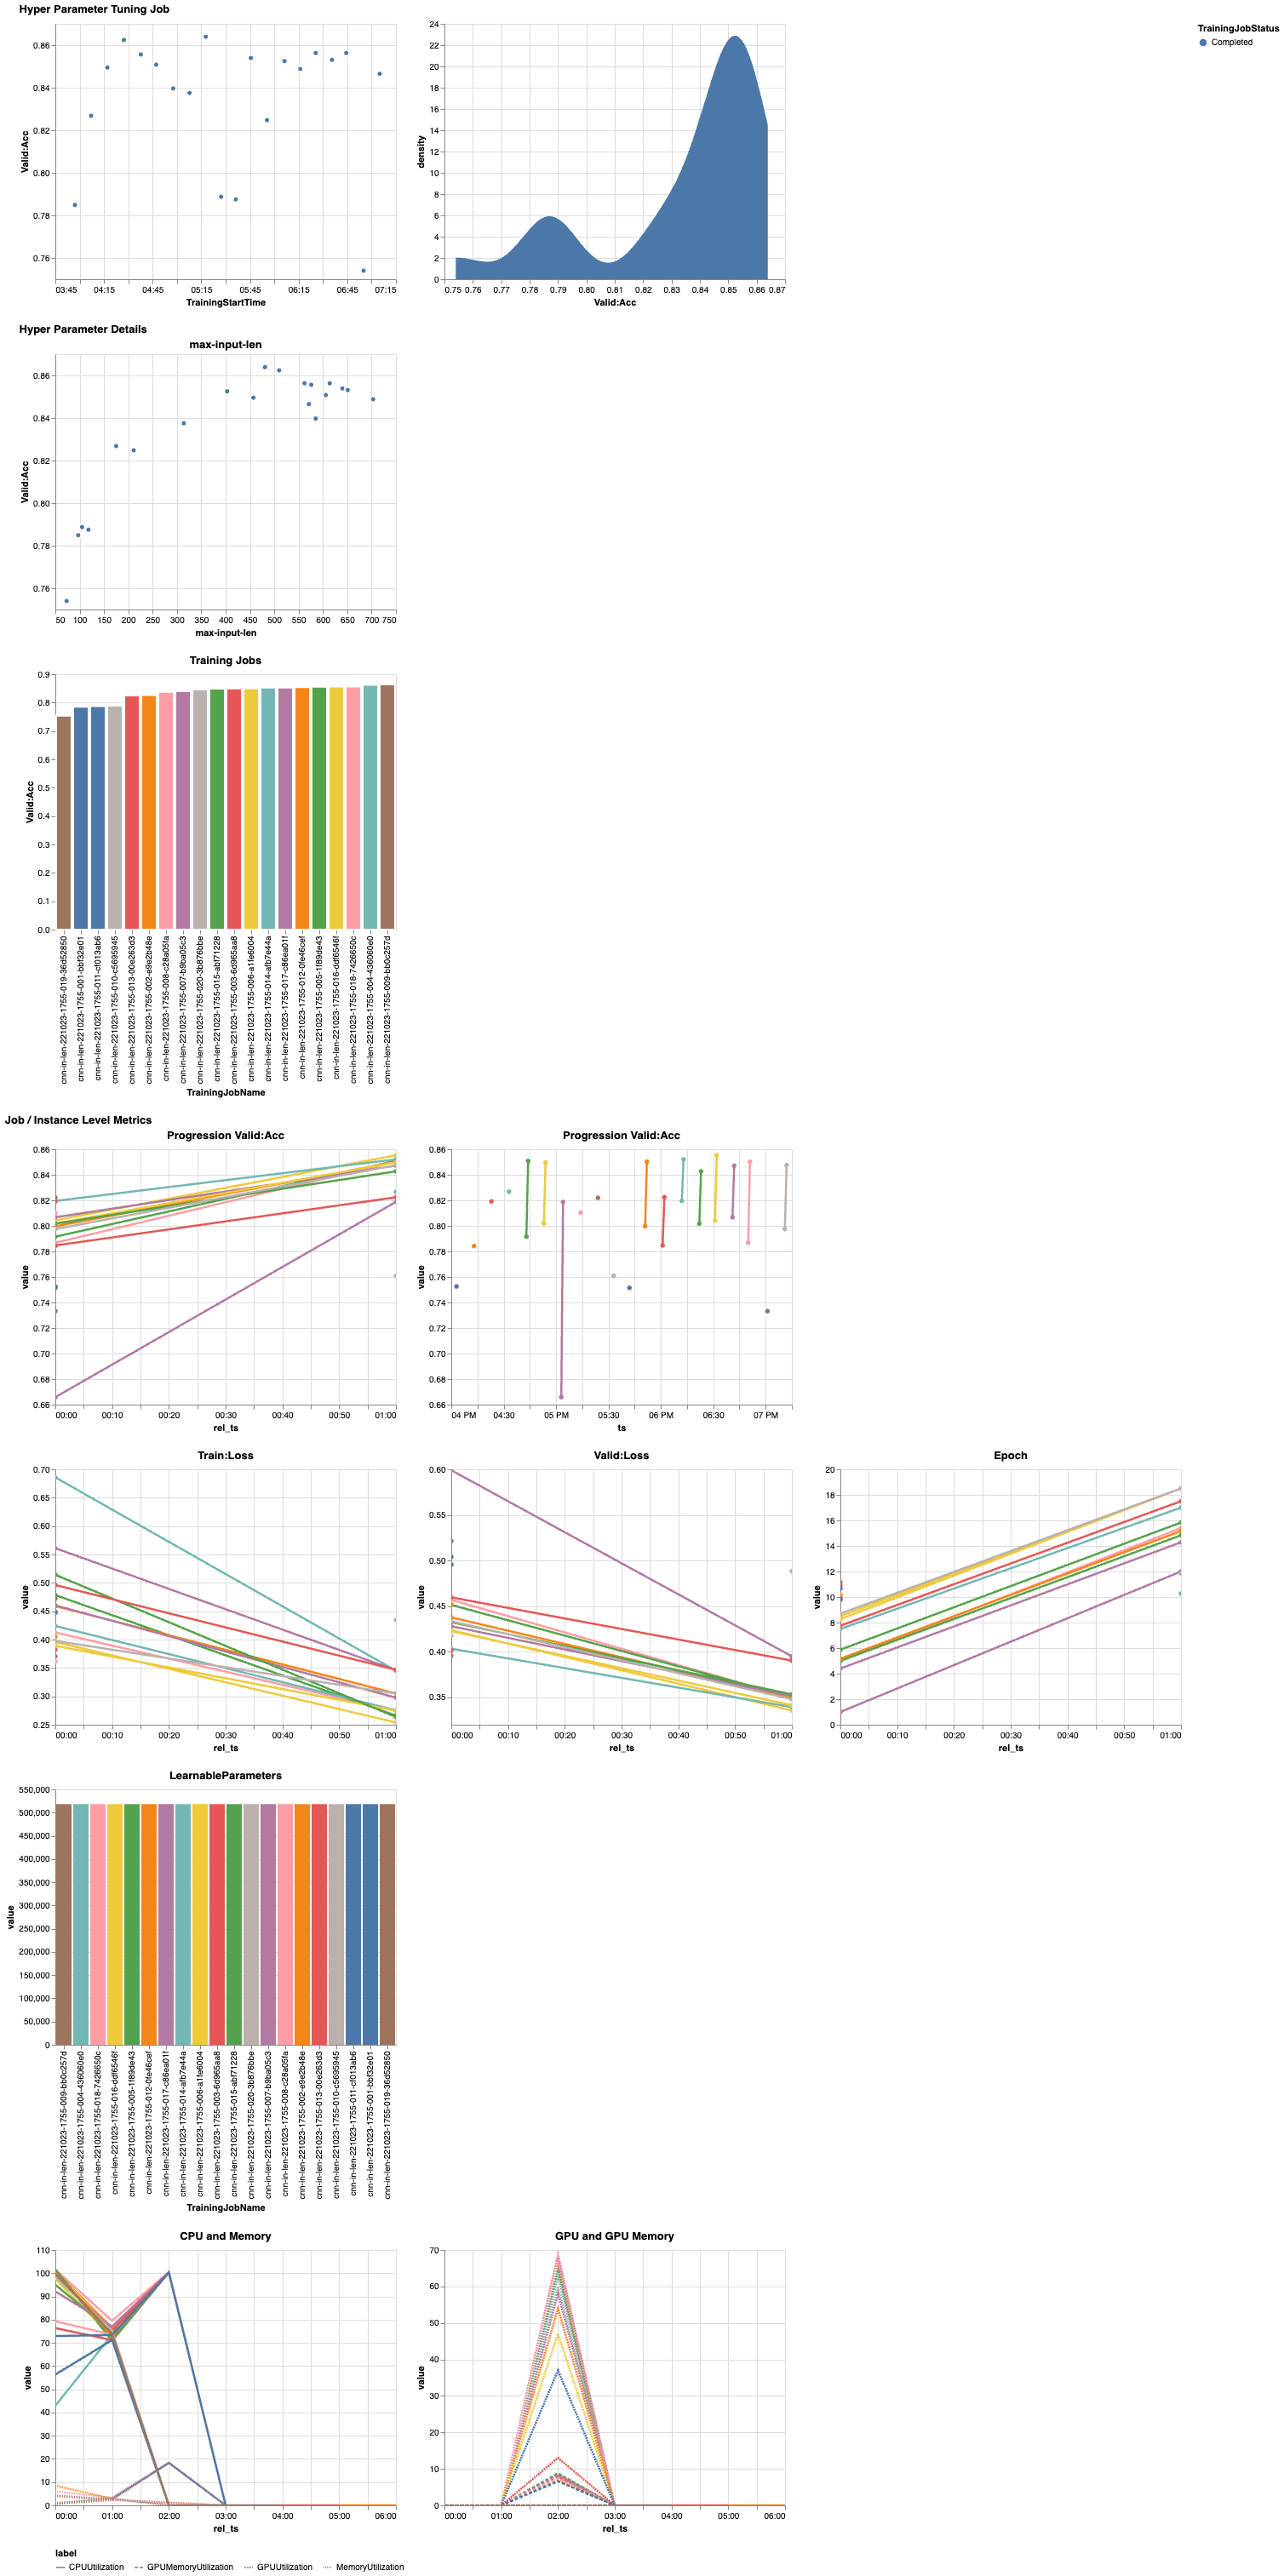

In [517]:
%%time
from reporting_util import analyze_hpo_job
chart, trials_df, full_df = analyze_hpo_job(
    v_size_to, 
    return_dfs=True,
    job_metrics=[
        'Train:Loss',
        'Valid:Loss',
        'Epoch',
        'LearnableParameters'
    ]
)
chart 

In [ ]:
XXX

In [400]:
%%time
import re
import numpy as np
word_counts = np.array([len(re.findall(r'\w+', text)) for _, text in train_dp])
word_counts.shape, np.min(word_counts), np.median(word_counts), word_counts.mean()

CPU times: user 1.17 s, sys: 21.5 ms, total: 1.19 s
Wall time: 1.19 s


((25000,), 10, 181.0, 242.27492)

In [401]:
#!pip install -Uq revtok spacy moses

In [402]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
word_counts_basic = np.array([len(tokenizer(text)) for _, text in train_dp])


%time word_counts_subwords = np.array([len(np.array(list(sp_tokenizer([text]))).flatten()) for _, text in train_dp])

CPU times: user 9.91 s, sys: 63.8 ms, total: 9.97 s
Wall time: 9.98 s


In [219]:
trials_df

max-input-len                      TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds           TuningJobName  Valid:Acc
1         1942.0  cnn-in-len-221023-1140-007-4e6cdddf         Completed 2022-10-23 12:46:23+02:00 2022-10-23 12:54:12+02:00                       469.0  cnn-in-len-221023-1140     0.8601
5          794.0  cnn-in-len-221023-1140-003-57d8e790         Completed 2022-10-23 12:04:42+02:00 2022-10-23 12:12:14+02:00                       452.0  cnn-in-len-221023-1140     0.8564
7         2685.0  cnn-in-len-221023-1140-001-b475b819         Completed 2022-10-23 11:42:42+02:00 2022-10-23 11:50:15+02:00                       453.0  cnn-in-len-221023-1140     0.8532
3         2553.0  cnn-in-len-221023-1140-005-70b24897         Completed 2022-10-23 12:26:28+02:00 2022-10-23 12:34:06+02:00                       458.0  cnn-in-len-221023-1140     0.8523
2          607.0  cnn-in-len-221023-1140-006-b11b9323         Completed 2022-10-23 12:37:04+02:00 2022-10-23 12:44:12+02:00                       428.0  cnn-in-len-221023-1140     0.8475
4         3907.0  cnn-in-len-221023-1140-004-a9d9f809         Completed 2022-10-23 12:14:34+02:00 2022-10-23 12:22:33+02:00                       479.0  cnn-in-len-221023-1140     0.8467
6         3136.0  cnn-in-len-221023-1140-002-6355c725         Completed 2022-10-23 11:52:12+02:00 2022-10-23 12:01:01+02:00                       529.0  cnn-in-len-221023-1140     0.8443

In [403]:
df_simple   = pd.DataFrame(data= {'label': 'simple', 'counts': word_counts})
df_basic    = pd.DataFrame(data= {'label': 'basic english', 'counts': word_counts_basic})
df_subwords = pd.DataFrame(data= {'label': 'subwords', 'counts': word_counts_subwords})

df = pd.concat((df_simple, df_basic, df_subwords), axis=0)

In [404]:
# tokenizer = get_tokenizer('subword')
# tokenizer('this is just an test to try out an attempt on a washingmachine unknownwird which is running.')

In [405]:
df.groupby('label').describe()

counts                                                          
                 count       mean         std   min    25%    50%    75%     max
label                                                                           
basic english  25000.0  270.68748  200.185691  11.0  147.0  202.0  329.0  2752.0
simple         25000.0  242.27492  179.876908  10.0  131.0  181.0  295.0  2525.0
subwords       25000.0  366.84840  285.184281  11.0  189.0  269.0  447.0  4294.0

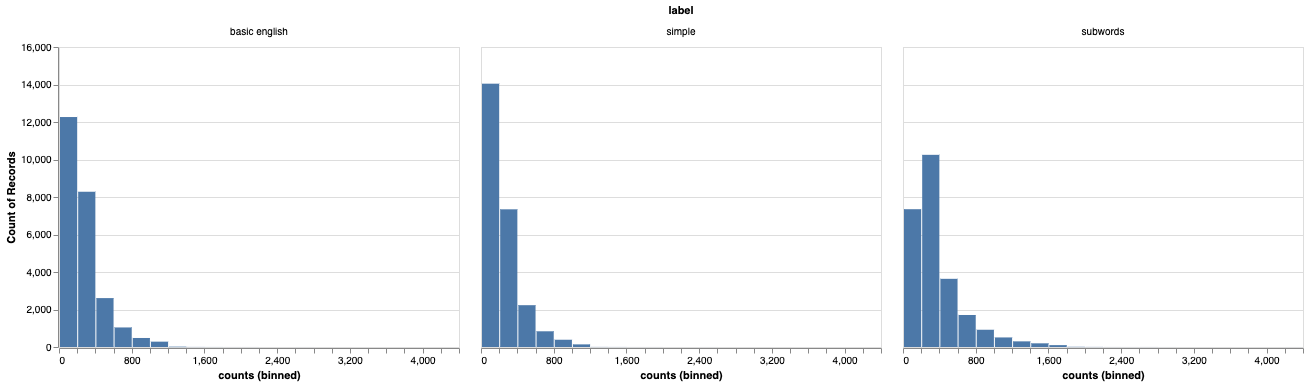

In [406]:
import altair as alt
import pandas as pd
# pd.DataFrame(data={'counts': word_counts}) 
alt.Chart(df).mark_bar().encode( 
    x=alt.X('counts:Q', bin=alt.Bin(maxbins=30), sort=None),
    y='count()',
    tooltip='median(counts)'   
).facet('label:N')

In [412]:
from torchtext.data.functional import generate_sp_model

from pathlib import Path
input_file = Path('data')/'sp_input'
output_dir = Path('data')/'sp_out'

if not input_file.exists():
    with open(input_file, 'w') as f:
        for _, text in train_dp:
            f.write(text+'\n')
if not output_dir.exists():
    output_dir.mkdir(exist_ok=True)

# Outputs, among others: Updating active symbols. max_freq=705466 min_freq=168    
generate_sp_model(str(input_file), vocab_size=4000, model_type='bpe', model_prefix=f'{output_dir}/sp_out')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=data/sp_input --model_prefix=data/sp_out/sp_out --vocab_size=4000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/sp_input
  input_format: 
  model_prefix: data/sp_out/sp_out
  model_type: BPE
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pa

CPU times: user 4.5 s, sys: 47.3 ms, total: 4.55 s
Wall time: 3.95 s


bpe_model_trainer.cc(258) LOG(INFO) Added: freq=324 size=3780 all=84202 active=4751 piece=▁include
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=322 size=3800 all=84378 active=4927 piece=▁Christopher
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=321 min_freq=119
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=319 size=3820 all=84609 active=4449 piece=ledge
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=317 size=3840 all=84659 active=4499 piece=▁steal
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=315 size=3860 all=84821 active=4661 piece=▁formula
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=312 size=3880 all=85083 active=4923 piece=rick
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=310 size=3900 all=85213 active=5053 piece=▁falling
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=310 min_freq=115
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=308 size=3920 all=85382 active=4430 piece=▁forgotten
trainer_interface.cc(604) LOG(INFO) S

In [174]:
from torchtext.data.functional import load_sp_model
sp_model = load_sp_model('m_user.model')
sp_tokenizer = sentencepiece_tokenizer(sp_model)
l = list(tokenizer(['one two three', 'four five six', 'example to try', 'washing machine running automation']))

AttributeError: 'list' object has no attribute 'lower'

In [163]:
l = [['a', 'b'], ['c', 'd']]

In [ ]:
[num for elem in vec for num in elem]

array(['a', 'b', 'c', 'd'], dtype='<U1')

In [ ]:
# sample 256 tokens from t, m, e